# Augment Data

## Visualize data

In [1]:
from config import DataConfig

data_config = DataConfig("custom_test")

node_path, edge_path = data_config.get_dataset_paths()
node_path

{'OK': {'2_ammf': {'M=mlC14_E1_set01': ['c:\\AFD_thesis\\data\\datasets\\asml\\NXE\\full_wafer\\healthy\\M=mlC14_E1_set01\\processed\\nodes\\2_ammf\\acc_x\\acc_x.hdf5',
    'c:\\AFD_thesis\\data\\datasets\\asml\\NXE\\full_wafer\\healthy\\M=mlC14_E1_set01\\processed\\nodes\\2_ammf\\acc_y\\acc_y.hdf5',
    'c:\\AFD_thesis\\data\\datasets\\asml\\NXE\\full_wafer\\healthy\\M=mlC14_E1_set01\\processed\\nodes\\2_ammf\\acc_z\\acc_z.hdf5']},
  '3_lra': {'M=mlC14_E1_set01': ['c:\\AFD_thesis\\data\\datasets\\asml\\NXE\\full_wafer\\healthy\\M=mlC14_E1_set01\\processed\\nodes\\3_lra\\pos_x\\pos_x.hdf5',
    'c:\\AFD_thesis\\data\\datasets\\asml\\NXE\\full_wafer\\healthy\\M=mlC14_E1_set01\\processed\\nodes\\3_lra\\pos_y\\pos_y.hdf5',
    'c:\\AFD_thesis\\data\\datasets\\asml\\NXE\\full_wafer\\healthy\\M=mlC14_E1_set01\\processed\\nodes\\3_lra\\pos_z\\pos_z.hdf5']}},
 'NOK': None,
 'UK': None}

In [1]:
from prep import DataPreprocessor
from config import DataConfig

data_config = DataConfig(run_type='custom_test')
data_preprocessor = DataPreprocessor(package='fault_detection')

dataloader, _ = data_preprocessor.get_custom_data_package(data_config, batch_size=4)

'fs' is updated in data_config as given in loaded healthy (or unknown) data.
New fs:
[[2499.5852, 2499.5852, 2499.5852],
 [9986.438 , 9986.438 , 9986.438 ]]


Node and signal types are set as follows:

(<node_num>) <node_type> : [<signal_types>]
---------------------------------------------
(1) 2_ammf   : [acc_x, acc_y, acc_z]
(2) 3_lra   : [pos_x, pos_y, pos_z]


Total samples: 13, 
Desired samples: 13 [OK=13, NOK=0, UK=0], 
Remainder samples: 0 [OK=0, NOK=0, UK=0]


In [3]:
data_config.fs

array([[2499.5852, 2499.5852, 2499.5852],
       [9986.438 , 9986.438 , 9986.438 ]], dtype=float32)

In [4]:
dataiter = iter(dataloader)
data, node_label = next(dataiter)

In [5]:
data.shape

torch.Size([4, 2, 4000, 3])

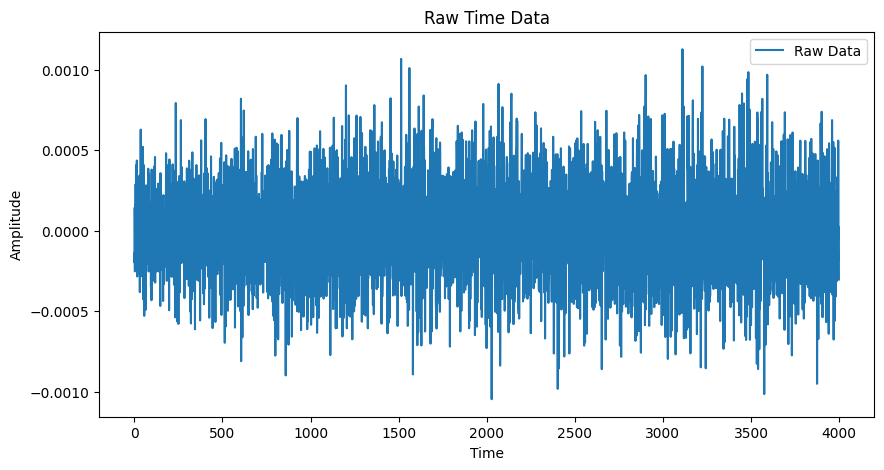

In [6]:
# visualize raw time data
import matplotlib.pyplot as plt

rep = 0
node = 1
dim = 0

plt.figure(figsize=(10, 5))
plt.plot(data[rep, node-1, :, dim], label='Raw Data')
plt.title('Raw Time Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [29]:
from transform import high_pass_filter, to_freq_domain

filtered_data = high_pass_filter(data, cutoff_freq=100, fs=data_config.fs)

print(filtered_data.shape)

torch.Size([4, 2, 4000, 3])


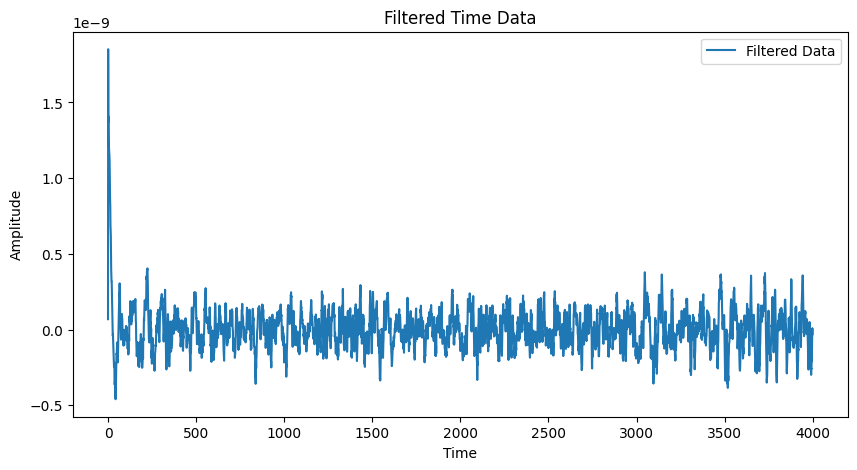

In [ ]:
# visualize filtered time data
plt.figure(figsize=(10, 5))
plt.plot(filtered_data[rep, node-1, :, dim], label='Filtered Data')
plt.title('Filtered Time Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()


In [31]:
from transform import to_freq_domain
freq_mag, freq_bins = to_freq_domain(data, data_config.fs)
print("freq_mag shape:", freq_mag.shape, "\nfreq_bin shape:", freq_bins.shape)

freq_mag shape: torch.Size([4, 2, 2000, 3]) 
freq_bin shape: torch.Size([4, 2, 2000, 3])


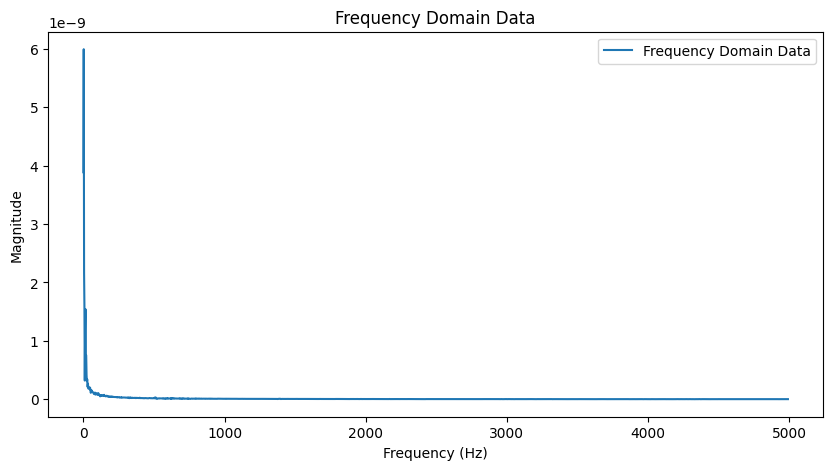

In [ ]:
# plot frequency domain data
plt.figure(figsize=(10, 5))
plt.plot(freq_bins[rep, node-1, :, dim], freq_mag[rep, node-1, :, dim], label='Frequency Domain Data')
plt.title('Frequency Domain Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

In [7]:
dataiter = iter(train_loader)
data, label = next(dataiter)

In [9]:
print("label shape", label.shape)
label

label shape torch.Size([50, 1])


tensor([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [ ]:
import numpy as np
import h5py
from collections import defaultdict
from augment import add_gaussian_noise
from prep import segment_data

def process_node_and_edge_data(node_path, edge_path, data_config):
    """
    Note
    ----
    - This method guarantees alignment between node and edge data per `ds_subtype`
    - `node_path` and `edge_path` must have same `ds_subtype` keys.
    - `n_samples` is the sum over all ds_subtypes of their respective `min_segments` among the dimensions
    """
    # node_type -> ds_subtype -> dim -> segments
    node_dim_collect = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # ds_subtype -> flat_edge
    ds_subtype_edge_map = {}

    # Step 1: Process node data
    for node_type, ds_subtype_paths in node_path['OK'].items():
        for ds_subtype, signal_type_paths in ds_subtype_paths.items():
            for dim_idx, hdf5_path in enumerate(signal_type_paths):
                with h5py.File(hdf5_path, 'r') as f:
                    data = f['data'][:]
                    label = f['label'][()]

                    # Apply augmentations
                    if data_config.healthy_configs[ds_subtype] != []:
                        for augment_config in data_config.healthy_configs[ds_subtype]:
                            if augment_config['type'] == 'gau':
                                data = add_gaussian_noise(data, augment_config['mean'], augment_config['std'])

                    data_segments = segment_data(data, data_config.window_length, data_config.stride)
                    data_segments = np.expand_dims(data_segments, axis=-1)  # (segments, timesteps, 1)

                    # store segments
                    node_dim_collect[node_type][ds_subtype][dim_idx].append(data_segments)

    # Step 2: Flatten edge matrices per ds_subtype
    for ds_subtype, edge_hdf5_path in edge_path['OK'].items():
        with h5py.File(edge_hdf5_path, 'r') as f:
            adj_mat = f['adj_mat'][:]  # shape: (n_nodes, n_nodes)

        flat_edge = []
        for r in range(adj_mat.shape[0]):
            for c in range(adj_mat.shape[1]):
                if r != c:
                    flat_edge.append(adj_mat[r, c])
        ds_subtype_edge_map[ds_subtype] = np.array(flat_edge)

    # Step 3: Combine all ds_subtype-wise node data across nodes
    all_ds_subtype_node_blocks = []  # each: (n_samples, n_nodes, t, d)
    all_ds_subtype_edges = []        # each: (n_samples, n_edges)

    for ds_subtype in edge_path['OK'].keys():
        per_node_tensors = []

        for node_type in sorted(node_path['OK'].keys()):
            dim_segment_arrays = []

            for dim_idx in sorted(node_dim_collect[node_type][ds_subtype].keys()):
                all_segments = np.concatenate(node_dim_collect[node_type][ds_subtype][dim_idx], axis=0)
                dim_segment_arrays.append(all_segments)

            # truncate to min_segments across dims
            min_segments = min(arr.shape[0] for arr in dim_segment_arrays)
            trimmed_segments = [arr[:min_segments] for arr in dim_segment_arrays]

            # concatenate dims → (min_segments, t, n_dims)
            node_tensor = np.concatenate(trimmed_segments, axis=-1)
            per_node_tensors.append(node_tensor)

        # Now we have list of (min_segments, t, n_dims) for each node
        # stack nodes → (min_segments, n_nodes, t, n_dims)
        node_block = np.stack(per_node_tensors, axis=1)
        all_ds_subtype_node_blocks.append(node_block)

        # copy flat edge per segment
        edge_vec = ds_subtype_edge_map[ds_subtype]
        edge_block = np.tile(edge_vec, (min_segments, 1))  # (min_segments, n_edges)
        all_ds_subtype_edges.append(edge_block)

    # Step 4: Final concatenation across ds_subtypes
    final_node_data = np.concatenate(all_ds_subtype_node_blocks, axis=0)  # (n_samples, n_nodes, t, d)
    final_edge_data = np.concatenate(all_ds_subtype_edges, axis=0)        # (n_samples, n_edges)
    final_labels = np.zeros((final_node_data.shape[0], 1), dtype=np.float32)

    return final_node_data, final_edge_data, final_labels

In [5]:
final_node_data, final_edge_data, final_labels = process_node_and_edge_data(node_path, edge_path, data_config)

In [6]:
print("Node data shape:", final_node_data.shape)
print("Edge data shape:", final_edge_data.shape)
print("Labels shape:", final_labels.shape)

Node data shape: (2435, 1, 500, 1)
Edge data shape: (2435, 20)
Labels shape: (2435, 1)


#### Load data

In [4]:
import h5py
import torch
from augment import add_gaussian_noise
from prep import segment_data
from collections import defaultdict
import numpy as np

# key: node_type, value: list of (n_samples, n_timesteps, 1)
node_dim_collect = defaultdict(lambda: defaultdict(list))

for node_type, ds_subtype_paths in node_path['OK'].items():
    for ds_subtype, signal_type_paths in ds_subtype_paths.items():

        with h5py.File(edge_path['OK'][ds_subtype], 'r') as f:
            # load edge data
            edge_data = f['adj_mat'][:]

        for dim_idx, hdf5_path in enumerate(signal_type_paths):
            with h5py.File(hdf5_path, 'r') as f:
                # load data and labels
                data = f['data'][:]
                label = f['label'][()]

                # augment data if needed
                if data_config.healthy_configs[ds_subtype] != []:

                    for augment_config in data_config.healthy_configs[ds_subtype]:
                        if augment_config['type'] == 'gau':
                            data = add_gaussian_noise(data, augment_config['mean'], augment_config['std'])

                        # add more augmentations as needed

                # segment data into segments
                data_segments = segment_data(data, data_config.window_length, data_config.stride)

                # (n_segments, window_length) -> (n_segments, window_length, 1)
                data_segments = np.expand_dims(data_segments, axis=-1)
                
                # append to corresponding node and dimension
                node_dim_collect[node_type][dim_idx].append(data_segments)

node_arrays = []

for node_type in sorted(node_dim_collect.keys()):  # sort to ensure order
    dim_segments = []

    for dim_idx in sorted(node_dim_collect[node_type].keys()):
        segments_list = node_dim_collect[node_type][dim_idx]
        # (n_total_segments, window_length, 1)
        dim_segments.append(np.concatenate(segments_list, axis=0))
    
    # now we have list of (n_samples, n_timesteps, 1) for each dim
    # stack on last axis to make (n_samples, n_timesteps, n_dims)
    node_array = np.concatenate(dim_segments, axis=-1)
    node_arrays.append(node_array)

# node_tensors: list of (n_samples, n_timesteps, n_dims)
# stack along nodes to get shape: (n_samples, n_nodes, n_timesteps, n_dims)
ds_h_np = np.stack(node_arrays, axis=1)

# Convert to torch tensor
ds_h_tensor = torch.tensor(ds_h_np, dtype=torch.float32)

# [TODO] 
# step 1. do the same for unhealthy data: ds_uh_tensor

# step 2.
# (if package is topology_estimation)
    # make ds_all = with edge label, MAKE torch.Dataset, combining ds_h_tensor and ds_uh_tensor
# (if package is fault detection)
    # make ds_all = with node label (ok, nok), MAKE torch.Dataset, combining ds_h_tensor and ds_uh_tensor

# step 3.
# (if run_type is 'train') 
    # divide into train, test, val sets
# (if run_type is 'test' or predict)
    # Make one set, which will be % of amt set in config

# step 4. make datalaoder using the sets

                 

In [5]:
edge_data

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0]], dtype=int32)

In [ ]:
print(ds_h_tensor.size())  # should be (n_samples, n_nodes, n_timesteps, n_dims)

torch.Size([2435, 1, 500, 1])


In [ ]:
print("h_label", type(label_h))
print("h_data", type(org_data['UH']))

h_label <class 'numpy.int64'>
h_data <class 'numpy.ndarray'>


In [5]:
print("h", label_h)
print('uh', label_uh)

h 0
uh 1


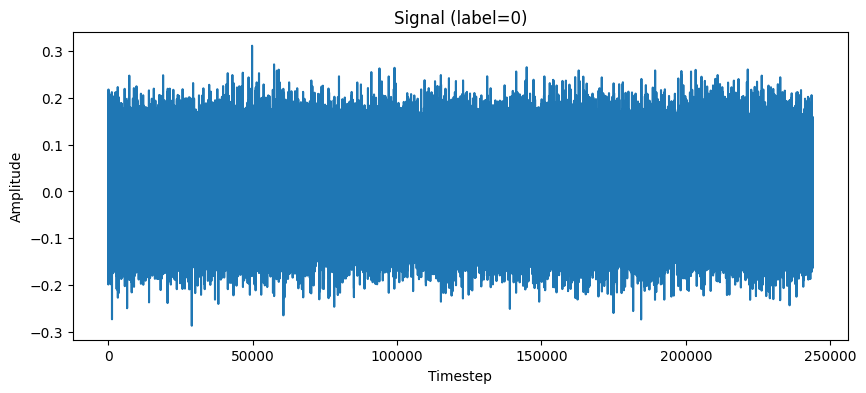

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(data_h_list[0][0])
plt.title(f"Signal (label={label_h_list[0]})")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.show()

#### Convert to shape (n_samples, n_nodes, n_timesteps, n_dim)

In [ ]:
org_data['H']